# Figures and Tables for the paper

In [30]:
from pathlib import Path
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })

### Constants

In [32]:
# DECIDE THE SUBSET TO USE
WHICH_SUBSET = 'SUM'  # Options are 'COOD', 'CMIX' and 'SUM'. SUM is the combination of COOD and CMIX

# Constants for dataframes
INITIAL_COLUMNS = ['Method', 'which_split', 'conf_thr_train', 'conf_thr_test', 'tpr_thr',
       'cluster_method', 'mean_n_clus', 'std_n_clus', 'fusion_strat',
       'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 'mAP',
       'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)', 'A-OSE',
       'WI-08', 'mAP_(VOC_test)', 'Model', 'args', 'custom_hyp']

FINAL_COLUMNS = ['Method', 'cluster_method', 'fusion_strat',
                 'mAP_(VOC_test)',
                 'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                 'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08', 'U-F1_(SUM)']

FINAL_COLUMNS_WITH_CONF_THR = ['Method', 'cluster_method',
                                'conf_thr_test',
                                'mAP_(VOC_test)',
                                'U-AP_(COOD)', 'U-F1_(COOD)', 'U-PRE_(COOD)', 'U-REC_(COOD)', 
                                'mAP', 'U-AP_(CMIX)', 'U-F1_(CMIX)', 'U-PRE_(CMIX)', 'U-REC_(CMIX)','A-OSE', 'WI-08']

COLUMNS_FOR_LATEX = ['Distance', 'Cluster Method',
                     'mAP',
                     'U-AP', 'U-F1', 'U-PRE', 'U-REC',
                     'mAP', 'U-AP', 'U-F1', 'U-PRE', 'U-REC', 'A-OSE', 'WI']

LATEX_PARAMS = {
    'index': False,
    'float_format': '%.3f',
    'bold_rows': True,
    'header': COLUMNS_FOR_LATEX,
}

NEW_NAMES_FOR_METHODS = {
    'L1_cl_stride': '$L_1$',
    'L2_cl_stride': '$L_2$',
    'Cosine_cl_stride': 'Cosine',
    'L1Ivis': '$L^{SDR}_1$',
    'L2Ivis': '$L^{SDR}_2$',
    'CosineIvis': 'Cosine$^{SDR}$',
    'MSP': 'MSP',
    'Energy': 'Energy',
    'ODIN': 'ODIN',
    'fusion-MSP-Energy': 'MSP-Energy',
    'fusion-MSP-Energy-ODIN': 'MSP-Energy-ODIN',
    'fusion-MSP-Cosine_cl_stride': 'MSP-Cosine',
    'fusion-MSP-CosineIvis': 'MSP-Cosine$^{SDR}$',
    'fusion-Cosine_cl_stride-CosineIvis': 'Cosine-Cosine$^{SDR}$',
    }

CLUSTER_METHODS_TO_KEEP = ['one', 'all', 'KMeans', 'KMeans_10', 'HDBSCAN', '-', 'KMeans_10-HDBSCAN']
NEW_NAMES_FOR_CLUSTER_METHODS = {
    'one': '$One$',
    'all': '$All$',
    'DBSCAN': '$DBSCAN$',
    'KMeans': '$KMeans$',
    'KMeans_10': '$KMeans^{10}$',
    'HDBSCAN': '$HDBSCAN$',
    'AgglomerativeClustering': '$Agglomerative$',
    'KMeans_10-HDBSCAN': 'KMeans_10-$HDBSCAN$',
}

# Paths
NORMAL_TEX_PATH = Path("results/cluster_methods_results/normal_df_final.tex")
IV_TEX_PATH = Path("results/cluster_methods_results/iv_df_final.tex")
FIGURES_FOLDER = Path("figures")
RQ1_FIGURES_FOLDER = FIGURES_FOLDER / "RQ1"
RQ1_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ2_FIGURES_FOLDER = FIGURES_FOLDER / "RQ2"
RQ2_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ3_FIGURES_FOLDER = FIGURES_FOLDER / "RQ3"
RQ3_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)
RQ4_FIGURES_FOLDER = FIGURES_FOLDER / "RQ4"
RQ4_FIGURES_FOLDER.mkdir(parents=True, exist_ok=True)

# Plot style
default_markers = ['o', 'X', 's', 'D', '^', 'v', '<', '>', 'P', '*']
MARKERS = {
    '$L_1$': 's',
    '$L_2$': 'D',
    'Cosine': 'o',
    '$L^{SDR}_1$': 'h',
    '$L^{SDR}_2$': 'd',
    'Cosine$^{SDR}$': '8',
    'MSP': 'P',#'v',
    'Energy': 'P',#'P',
    'ODIN': 'P',#'X',
    '$ND_{prev}$': '*',
}

### Functions

In [33]:
def search_for_paths_with_extension(path: Path, extension=".csv") -> List[Path]:
    # Recursively search for all files with the extension
    paths = []
    for p in path:
        if p.is_dir():
            paths += search_for_paths_with_extension(list(p.iterdir()), extension)
        elif p.is_file() and p.suffix == extension:
            paths.append(p)
    return paths

def convert_list_of_paths_into_df(paths: list[Path], extension=".csv"):
    # Read the documents and concat into one big dataframe
    if len(paths) == 0:
        raise ValueError("No paths found")
    
    # Extrac the .csv files from the paths
    paths = search_for_paths_with_extension(paths, extension)
    print(paths)

    for doc in paths:
        df = pd.read_csv(doc)
        # Check if all initial columns are present. If not, add them 
        if not all(col in df.columns for col in INITIAL_COLUMNS):
            for col in INITIAL_COLUMNS:
                if col not in df.columns:
                    print(f"Column {col} not found in {doc}")
                    df[col] = np.nan
        
        # Check if the dataframe is the first one
        if doc == paths[0]:
            dataframe = df
        else:  # If not, concat the dataframes
            dataframe = pd.concat([dataframe, df])    

    return dataframe

def format_df(df, columns_to_keep=None):
    # CONTENT CHANGES
    if columns_to_keep:
        dataframe = df[columns_to_keep]
    else:
        dataframe = df[FINAL_COLUMNS]
    # Display only 3 decimals
    dataframe = dataframe.round(3)
    # Convert A-OSE to int
    dataframe['A-OSE'] = dataframe['A-OSE'].astype(int)
    # Replace NaNs with -
    dataframe = dataframe.fillna('-')
    # Keep only certain rows
    dataframe = dataframe[dataframe['cluster_method'].isin(CLUSTER_METHODS_TO_KEEP)]
    # Create a new column with the sum of F1 metric in CMIX and COOD
    dataframe['U-F1_(SUM)'] = dataframe['U-F1_(CMIX)'] + dataframe['U-F1_(COOD)']


    # NAME CHANGES
    # Change the Method names
    dataframe['Method'] = dataframe['Method'].replace(NEW_NAMES_FOR_METHODS)
    # Change the cluster method names
    dataframe['cluster_method'] = dataframe['cluster_method'].replace(NEW_NAMES_FOR_CLUSTER_METHODS)
    return dataframe


def obtain_best_values_of_columns(df, columns_to_search_max, columns_to_search_min):
    # Extract values to dicts of max and min values per
    max_values = {}
    min_values = {}
    for col in columns_to_search_max:
        df[col] = df.groupby(['Method'])[col].transform('max')
        max_values[col] = df[col].max().round(3)
    for col in columns_to_search_min:
        df[col] = df.groupby(['Method'])[col].transform('min')
        min_values[col] = df[col].min().round(3)
    return max_values, min_values  


def obtain_non_dominated_points_positions_map_f1(dataframe: pd.DataFrame, which_subset: str):
    non_dominated_points = []
    for i in range(len(dataframe)):
        is_dominated = False
        for j in range(len(dataframe)):
            if i == j:
                continue
            if dataframe['mAP'][i] < dataframe['mAP'][j] and dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]:
                is_dominated = True
                break
            else:
                # If the points are the same, then they are not dominated
                if dataframe['mAP'][i] == dataframe['mAP'][j] and dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                    pass
                else:
                    # If the points are the same in one of the metrics, then check the other metric
                    if dataframe['mAP'][i] == dataframe['mAP'][j]:
                        if dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]:
                            is_dominated = True
                            break
                    if dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                        if dataframe['mAP'][i] < dataframe['mAP'][j]:
                            is_dominated = True
                            break
        if not is_dominated:
            non_dominated_points.append(i)
    return non_dominated_points


def obtain_non_dominated_points_positions_map_f1_aose(dataframe: pd.DataFrame, which_subset: str):
    non_dominated_points = []
    for i in range(len(dataframe)):
        is_dominated = False
        for j in range(len(dataframe)):
            if i == j:
                continue
            if (
                dataframe['mAP'][i] < dataframe['mAP'][j] and
                dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j] and
                dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
            ):
                is_dominated = True
                break
            else:
                # If the points are the same, then they are not dominated
                if (
                    dataframe['mAP'][i] == dataframe['mAP'][j] and
                    dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j] and
                    dataframe['A-OSE'][i] == dataframe['A-OSE'][j]
                ):
                    pass
                else:
                    continue
                    # Check if the current point is dominated in one of the metrics
                    if dataframe['mAP'][i] == dataframe['mAP'][j]:
                        if (
                            dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j] and
                            dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
                        ):
                            is_dominated = True
                            break
                    if dataframe[f'U-F1_({which_subset})'][i] == dataframe[f'U-F1_({which_subset})'][j]:
                        if (
                            dataframe['mAP'][i] < dataframe['mAP'][j] and
                            dataframe['A-OSE'][i] > dataframe['A-OSE'][j]
                        ):
                            is_dominated = True
                            break
                    if dataframe['A-OSE'][i] == dataframe['A-OSE'][j]:
                        if (
                            dataframe['mAP'][i] < dataframe['mAP'][j] and
                            dataframe[f'U-F1_({which_subset})'][i] < dataframe[f'U-F1_({which_subset})'][j]
                        ):
                            is_dominated = True
                            break
        if not is_dominated:
            non_dominated_points.append(i)
    return non_dominated_points


from adjustText import adjust_text

def add_shaded_areas(df, ax, colors, subset_col, x_col, y_col, bw_adjust=0.3, alpha=0.2, levels=2):
    """
    Adds shaded areas to a plot based on kernel density estimation.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        ax (Axes): The axes on which to plot.
        colors (list): A list of colors for different cluster methods.
        subset_col (str): The column name to subset the DataFrame.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        bw_adjust (float): The bandwidth adjustment value for KDE.
        alpha (float): The alpha value for the shaded areas.
        levels (int): The number of contour levels to plot.
    """
    for method, color in zip(df[subset_col].unique(), colors):
        subset = df[df[subset_col] == method]
        sns.kdeplot(
            x=subset[x_col], 
            y=subset[y_col], 
            ax=ax, 
            fill=True, 
            color=color, 
            alpha=alpha, 
            legend=False, 
            bw_adjust=bw_adjust,
            linewidth=0, 
            levels=levels
        )


def highlight_non_dominated_points(ax, df, indices, x_col, y_col, marker_size, edge_color, linewidth, face_color='none', marker='o', zorder=0):
    """
    Highlights the non-dominated points on a plot.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        marker_size (int): The size of the markers.
        edge_color (str): The color of the edges of the markers.
        linewidth (float): The linewidth of the marker edges.
        face_color (str): The face color of the markers.
        marker (str): The marker style.
        zorder (int): The zorder of the markers.
    """
    for i in indices:
        ax.scatter(
            df[x_col][i], 
            df[y_col][i], 
            s=marker_size, 
            facecolors=face_color, 
            marker=marker, 
            zorder=zorder, 
            edgecolors=edge_color, 
            linewidths=linewidth
        )


def add_line_connecting_non_dominated_points(ax, df, indices, x_col, y_col, line_color, line_style='--', line_width=1):
    """
    Adds a line connecting the non-dominated points in descending order of y_col.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        line_color (str): The color of the line.
        line_style (str): The style of the line.
        line_width (float): The width of the line.
    """
    # Sort the non-dominated points in descending order of y_col
    indices.sort(key=lambda x: df[y_col][x], reverse=True)
    
    # Add lines connecting the sorted non-dominated points
    for i in range(len(indices)-1):
        x = [df[x_col][indices[i]], df[x_col][indices[i+1]]]
        y = [df[y_col][indices[i]], df[y_col][indices[i+1]]]
        ax.plot(x, y, c=line_color, linestyle=line_style, linewidth=line_width)


def add_text_to_non_dominated_points(ax, df, indices, x_col, y_col, text_col, fontsize, automatic_text_adjustment=True, offset_pos=0.002, offset_neg=-0.007):
    """
    Adds text to the non-dominated points with the value from text_col.

    Parameters:
        ax (Axes): The axes on which to plot.
        df (DataFrame): The DataFrame containing the data.
        indices (list): The indices of the non-dominated points.
        x_col (str): The column name for the x-axis data.
        y_col (str): The column name for the y-axis data.
        text_col (str): The column name for the text data.
        fontsize (int): The fontsize of the text.
        offset_pos (float): The positive offset for the text position.
        offset_neg (float): The negative offset for the text position.
    """
    added_text_points = []
    all_text = []
    for i in indices:
        x = df[x_col][i]
        y = df[y_col][i]
        if (x, y) in added_text_points:
            continue
            text = ax.text(x + offset_neg, y, df[text_col][i], fontsize=fontsize)
        else:
            text = ax.text(x + offset_pos, y, df[text_col][i], fontsize=fontsize)
        added_text_points.append((x, y))
        all_text.append(text)
    if automatic_text_adjustment:
        adjust_text(all_text)  #, ax=ax, expand_text=(1.01, 1.01), expand_points=(1.01, 1.01), arrowprops=dict(arrowstyle='-', color='black', lw=0.5))


def unique_legend_handles_labels(ax):
    """
    Manipulate the handles and labels of the legend so that the labels that appear twice are only shown once,
    and the color and marker of it are shown together.

    Parameters:
    ax (matplotlib.axes.Axes): The axes object containing the plot.

    Returns:
    tuple: Unique handles and labels for the legend.
    """
    # Extract the handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Search for the unique labels and their handles
    unique_labels = []
    unique_handles = []
    color_and_marker = []
    
    for i, label in enumerate(labels):
        # If the label is not in the unique labels, then add it
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handles[i])
            color_and_marker.append((handles[i].get_color(), handles[i].get_marker()))
        else:
            # Search for the index of the label in the unique labels
            index = unique_labels.index(label)
            # Obtain the color of the label
            prev_color = color_and_marker[index][0]
            # Modify the color of the current handle with the retrieved color
            handles[i].set_markerfacecolor(prev_color)
            # Add the color and marker to the color_and_marker list
            unique_labels.append(label)
            unique_handles.append(handles[i])
            color_and_marker.append((prev_color, handles[i].get_marker()))
            # Remove the retrieved label and handle
            unique_labels.pop(index)
            unique_handles.pop(index)
    
    return unique_handles, unique_labels


def pareto_front(df: pd.DataFrame, metrics: dict) -> pd.DataFrame:
    """
    Obtain the Pareto front for the selected metrics from the dataframe.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the results of different methods.
    - metrics (dict): Dictionary with metric names as keys and 'max' or 'min' as values indicating the optimization direction.

    Returns:
    - pd.DataFrame: DataFrame containing the Pareto front.
    """
    def is_dominated(candidate, others):
        """ Check if candidate is dominated by any of the points in others """
        for _, other in others.iterrows():
            better_in_all = True
            strictly_better_in_at_least_one = False
            for metric, direction in metrics.items():
                if direction == 'max':
                    if other[metric] > candidate[metric]:
                        strictly_better_in_at_least_one = True
                    if other[metric] < candidate[metric]:
                        better_in_all = False
                elif direction == 'min':
                    if other[metric] < candidate[metric]:
                        strictly_better_in_at_least_one = True
                    if other[metric] > candidate[metric]:
                        better_in_all = False
            if better_in_all and strictly_better_in_at_least_one:
                return True
        return False

    pareto_points = []
    pareto_positions = []
    for i, row in df.iterrows():
        candidate = row[metrics.keys()]
        if not is_dominated(candidate, df[metrics.keys()].drop(i)):
            pareto_points.append(row)
            pareto_positions.append(i)
    
    pareto_front_df = pd.DataFrame(pareto_points)
    return pareto_front_df, pareto_positions


## RQ1. Distance methods

### Figure 1: Comparison of distance methods

In [34]:
folders_to_consider = [
    Path("results/cluster_methods"),
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance Metric'})

# Prints
print(df_final['Distance Metric'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/cluster_methods/20240712_165027_conf_thr_test_Cosine_cl_stride_one.csv'), PosixPath('results/cluster_methods/20240712_165118_conf_thr_test_L2_cl_stride_KMeans.csv'), PosixPath('results/cluster_methods/20240712_165432_conf_thr_test_L2_cl_stride_KMeans_10.csv'), PosixPath('results/cluster_methods/20240712_161755_conf_thr_test_L1_cl_stride_KMeans_10.csv'), PosixPath('results/cluster_methods/20240712_194645_conf_thr_test_L1_cl_stride_one.csv'), PosixPath('results/cluster_methods/20240712_161740_conf_thr_test_L2_cl_stride_HDBSCAN.csv'), PosixPath('results/cluster_methods/20240703_073017_conf_thr_test_Cosine_cl_stride_HDBSCAN.csv'), PosixPath('results/cluster_methods/20240712_165624_conf_thr_test_L1_cl_stride_KMeans.csv'), PosixPath('results/cluster_methods/20240712_175600_conf_thr_test_L2_cl_stride_one.csv'), PosixPath('results/cluster_methods/20240712_194532_conf_thr_test_L1_cl_stride_HDBSCAN.csv'), PosixPath('results/cluster_methods/20240712_161122_conf_thr_test_Cosine

,Distance Metric,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
92,Cosine,$KMeans^{10}$,0.100,0.576,0.164,0.262,0.649,0.164,0.381,0.045,0.145,0.245,0.103,201,0.109,0.407
93,Cosine,$KMeans^{10}$,0.050,0.566,0.163,0.291,0.555,0.197,0.374,0.044,0.159,0.217,0.126,232,0.114,0.450
94,Cosine,$KMeans^{10}$,0.010,0.529,0.225,0.331,0.412,0.276,0.341,0.042,0.173,0.162,0.185,285,0.118,0.504
95,Cosine,$KMeans^{10}$,0.005,0.505,0.259,0.330,0.346,0.314,0.334,0.054,0.163,0.134,0.208,325,0.123,0.493
96,Cosine,$KMeans^{10}$,0.001,0.450,0.268,0.276,0.213,0.395,0.278,0.051,0.139,0.091,0.292,410,0.126,0.415


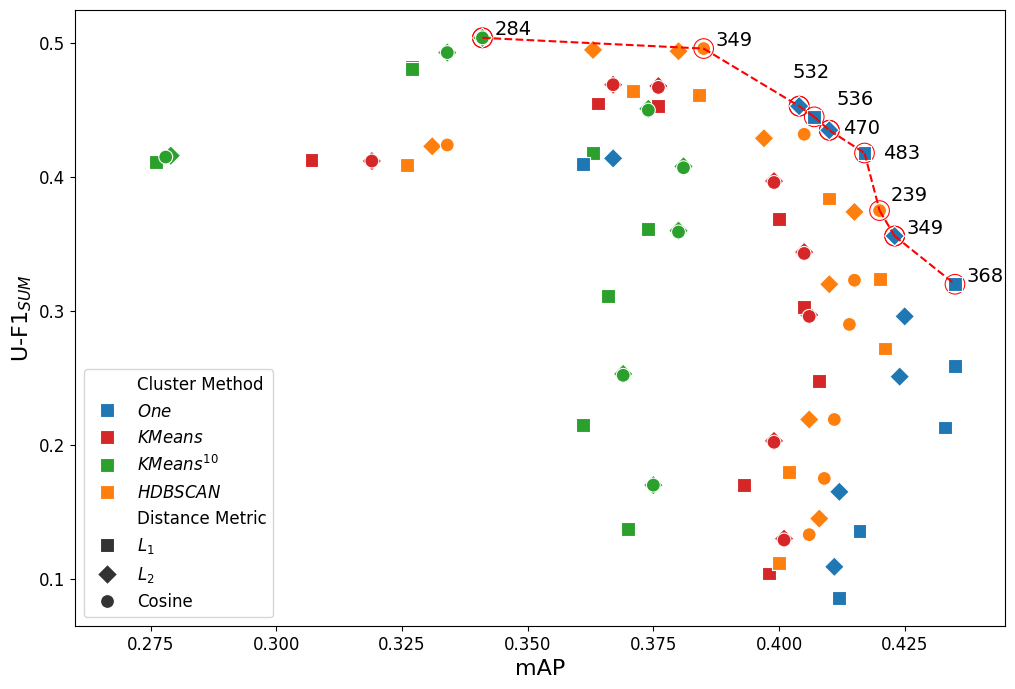

In [35]:
# Constants for the style of the plots
#STYLE_ORDER = ['$L_1$', '$L_2$', 'Cosine', '$L^{SDR}_1$', '$L^{SDR}_2$', 'Cosine$^{SDR}$', 'MSP', 'Energy', 'ODIN']
STYLE_ORDER = ['$L_1$', '$L_2$', 'Cosine']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False

# Constants
USE_LIMS = True
XLIM = (0.26, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.18)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.025, 0.35)
else:
    YLIM = (0.065, 0.525)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
# non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# # Extract the non-dominated points into a df
# df_non_dominated_cluster_methods = df_final.iloc[non_dominated_points]

df_non_dominated_cluster_methods, non_dominated_points = pareto_front(df_final, {
    'U-F1_(SUM)': 'max',
    'mAP': 'max',
    #'A-OSE': 'min',
    })


# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance Metric',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=MARKERS,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
#plt.ylabel(f'U-F1_$\{{WHICH_SUBSET}\}$)', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_SUBSET}_cluster_methods.pdf', bbox_inches='tight')
plt.show()

### Figure 2: Comparison of distance methods with SDR

#### Option 1: SDR + Non-dominated

In [36]:
# Obtain the SDR results
folders_to_consider = [
    Path("results/cluster_methods_SDR")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods_SDR = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods_SDR.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Obtaint the SDR non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_SDR = df_final.iloc[non_dominated_points]

# Obtain the non-dominated points with info about the distance metric and cluster method
df_final_cluster_methods_with_names = df_final.copy()
df_final_cluster_methods_with_names = pd.concat([df_final, df_non_dominated_cluster_methods]).reset_index(drop=True)

# ADD the non-dominated points of cluster_methods. First convert their method and cluster_method to non-dominated
df_non_dominated_cluster_methods_with_no_name = df_non_dominated_cluster_methods.copy()
df_non_dominated_cluster_methods_with_no_name['Distance'] = '$ND_{prev}$'
df_non_dominated_cluster_methods_with_no_name['Cluster Method'] = '$ND_{prev}$'
df_final = pd.concat([df_final, df_non_dominated_cluster_methods_with_no_name]).reset_index(drop=True)

# Save the DF with another name
df_final_cluster_methods = df_final.copy()

print(df_final['Distance'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/cluster_methods_SDR/20240716_102253_conf_thr_test_L2Ivis_HDBSCAN.csv'), PosixPath('results/cluster_methods_SDR/20240713_161713_conf_thr_test_CosineIvis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240716_101651_conf_thr_test_L2Ivis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240713_181123_conf_thr_test_CosineIvis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240713_151627_conf_thr_test_CosineIvis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_224806_conf_thr_test_L2Ivis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_224246_conf_thr_test_L1Ivis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240715_223911_conf_thr_test_L2Ivis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240715_154514_conf_thr_test_L1Ivis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_183820_conf_thr_test_L1Ivis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240713_181720_conf_thr_test_CosineIvis_HDBSCA

,Distance,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Distance Metric
104,$ND_{prev}$,$ND_{prev}$,0.010,0.577,0.219,0.327,0.431,0.264,0.385,0.045,0.169,0.173,0.165,349,0.125,0.496,Cosine
105,$ND_{prev}$,$ND_{prev}$,0.050,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139,0.356,$L_2$
106,$ND_{prev}$,$ND_{prev}$,0.010,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141,0.435,$L_2$
107,$ND_{prev}$,$ND_{prev}$,0.005,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136,0.453,$L_2$
108,$ND_{prev}$,$ND_{prev}$,0.010,0.529,0.225,0.331,0.412,0.276,0.341,0.042,0.173,0.162,0.185,285,0.118,0.504,Cosine


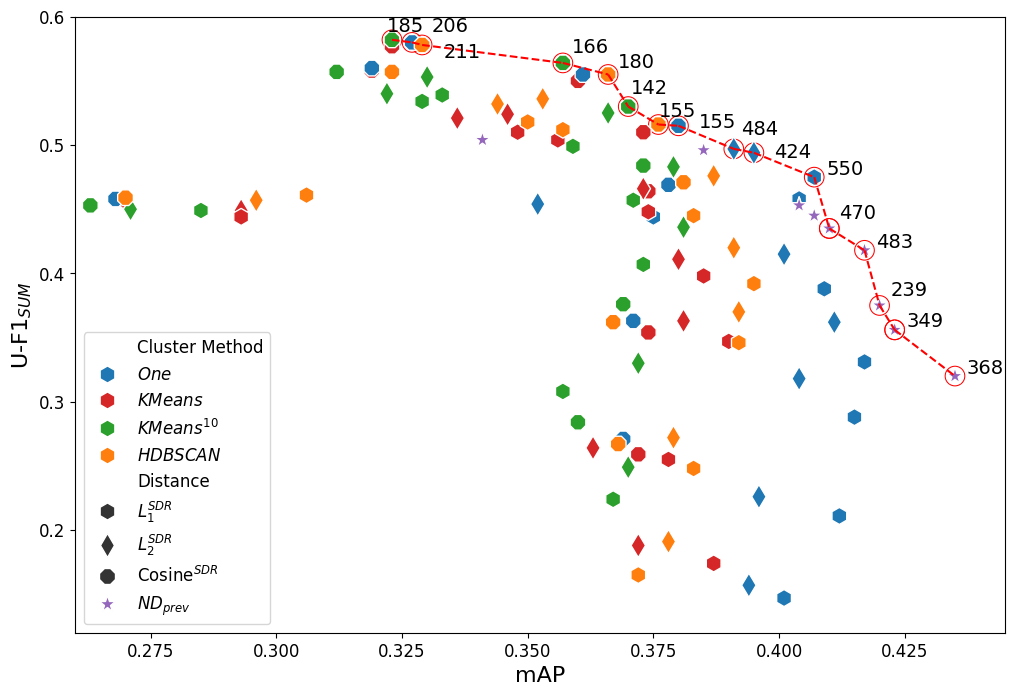

In [37]:
# Constants for the style of the plots
STYLE_ORDER = ['$L^{SDR}_1$', '$L^{SDR}_2$', 'Cosine$^{SDR}$', '$ND_{prev}$']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$', '$ND_{prev}$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.26, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.12, 0.60)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=MARKERS,
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_SUBSET}_cluster_methods_SDR_with_ND_prev.pdf', bbox_inches='tight')
plt.show()

#### Option 2: SDR only, then both non-dominated

In [38]:
# Obtain the SDR results
folders_to_consider = [
    Path("results/cluster_methods_SDR")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_cluster_methods_SDR = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_cluster_methods_SDR.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Obtaint the SDR non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_SDR = df_final.iloc[non_dominated_points]

# Save the DF with another name
df_final_cluster_methods_SDR = df_final.copy()

print(df_final['Distance'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/cluster_methods_SDR/20240716_102253_conf_thr_test_L2Ivis_HDBSCAN.csv'), PosixPath('results/cluster_methods_SDR/20240713_161713_conf_thr_test_CosineIvis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240716_101651_conf_thr_test_L2Ivis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240713_181123_conf_thr_test_CosineIvis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240713_151627_conf_thr_test_CosineIvis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_224806_conf_thr_test_L2Ivis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_224246_conf_thr_test_L1Ivis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240715_223911_conf_thr_test_L2Ivis_KMeans_10.csv'), PosixPath('results/cluster_methods_SDR/20240715_154514_conf_thr_test_L1Ivis_one.csv'), PosixPath('results/cluster_methods_SDR/20240715_183820_conf_thr_test_L1Ivis_KMeans.csv'), PosixPath('results/cluster_methods_SDR/20240713_181720_conf_thr_test_CosineIvis_HDBSCA

,Distance,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
91,$L^{SDR}_1$,$HDBSCAN$,0.100,0.568,0.167,0.264,0.701,0.162,0.395,0.024,0.128,0.263,0.084,244,0.119,0.392
92,$L^{SDR}_1$,$HDBSCAN$,0.050,0.556,0.167,0.300,0.622,0.198,0.383,0.046,0.145,0.239,0.104,287,0.124,0.445
93,$L^{SDR}_1$,$HDBSCAN$,0.010,0.519,0.228,0.343,0.472,0.269,0.357,0.044,0.169,0.182,0.157,379,0.127,0.512
94,$L^{SDR}_1$,$HDBSCAN$,0.005,0.497,0.268,0.349,0.404,0.308,0.350,0.044,0.169,0.157,0.182,431,0.129,0.518
95,$L^{SDR}_1$,$HDBSCAN$,0.001,0.449,0.277,0.310,0.255,0.395,0.306,0.055,0.151,0.107,0.259,550,0.108,0.461


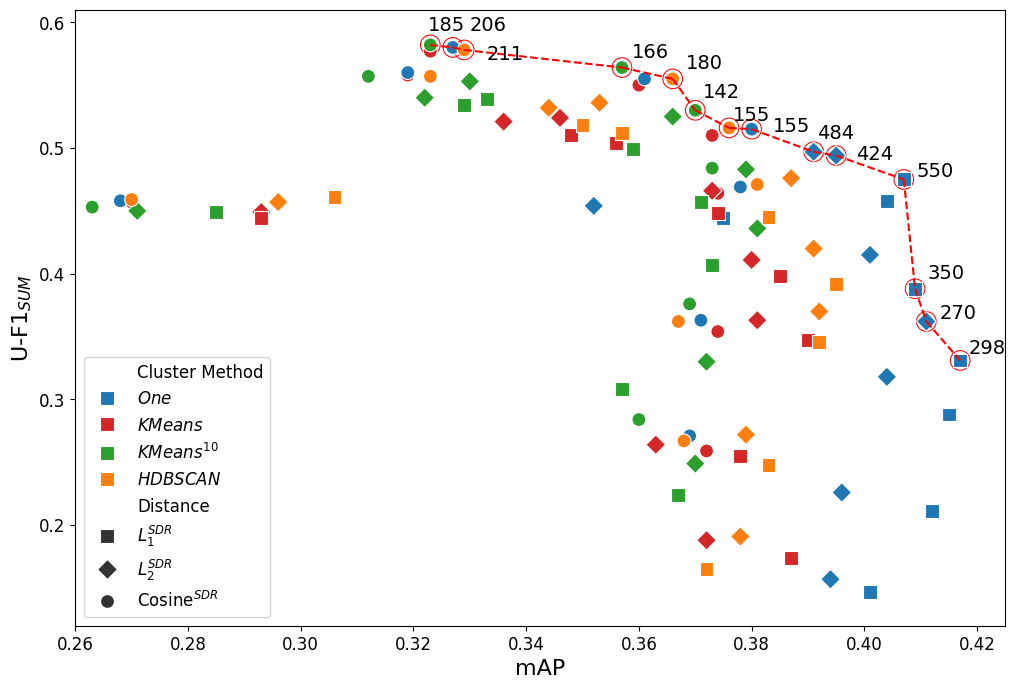

In [39]:
# Constants for the style of the plots
STYLE_ORDER = ['$L^{SDR}_1$', '$L^{SDR}_2$', 'Cosine$^{SDR}$']
HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$']
OTHER_MARKERS = {
    '$L^{SDR}_1$': 's',
    '$L^{SDR}_2$': 'D',
    'Cosine$^{SDR}$': 'o',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.26, 0.425)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.12, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_SUBSET}_cluster_methods_SDR.pdf', bbox_inches='tight')
plt.show()

In [40]:
df_non_dominated_cluster_methods_and_SDR

,Distance,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
27,Cosine$^{SDR}$,$KMeans^{10}$,0.100,0.520,0.241,0.362,0.663,0.249,0.370,0.049,0.168,0.266,0.123,142,0.082,0.530
28,Cosine$^{SDR}$,$KMeans^{10}$,0.050,0.507,0.241,0.384,0.581,0.287,0.357,0.047,0.180,0.235,0.145,166,0.085,0.564
29,Cosine$^{SDR}$,$KMeans^{10}$,0.010,0.471,0.296,0.392,0.427,0.363,0.323,0.061,0.190,0.174,0.209,185,0.082,0.582
35,Cosine$^{SDR}$,$One$,0.100,0.527,0.238,0.351,0.668,0.238,0.380,0.051,0.164,0.275,0.116,155,0.087,0.515
37,Cosine$^{SDR}$,$One$,0.010,0.477,0.292,0.389,0.433,0.352,0.327,0.062,0.191,0.181,0.203,206,0.086,0.580
43,$L^{SDR}_2$,$One$,0.100,0.597,0.164,0.248,0.713,0.150,0.411,0.022,0.114,0.240,0.075,270,0.127,0.362
45,$L^{SDR}_2$,$One$,0.010,0.581,0.223,0.333,0.480,0.255,0.395,0.040,0.161,0.185,0.143,424,0.133,0.494
46,$L^{SDR}_2$,$One$,0.005,0.573,0.224,0.334,0.408,0.283,0.391,0.041,0.163,0.161,0.164,484,0.129,0.497
67,$L^{SDR}_1$,$One$,0.100,0.636,0.165,0.231,0.732,0.137,0.417,0.021,0.100,0.232,0.064,298,0.135,0.331
68,$L^{SDR}_1$,$One$,0.050,0.635,0.167,0.271,0.647,0.171,0.409,0.021,0.117,0.218,0.080,350,0.144,0.388


### Figure 3. Enhanced Unknonw Localization (EUL) with distance methods

In [41]:
# Copy the dataframe and empty it
df_non_dominated_cluster_methods_and_SDR_with_EUL = df_final.copy()
df_non_dominated_cluster_methods_and_SDR_with_EUL = df_non_dominated_cluster_methods_and_SDR_with_EUL.iloc[0:0]
df_non_dominated_cluster_methods_and_SDR_with_EUL

,Distance,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)


### Table and Figure 4. Non-dominated solutions with distance methods

In [42]:
# Collect the non-dominated points of the cluster methods.
# Name them as f"Non-dominated {name}$"" and add them to the df
# The name will depend on where they came from. If just cluster methods, then it will be Non-dominated vanilla
# If they come from SDR, then it will be Non-dominated SDR

# Vanilla
df_non_dominated_cluster_methods_new_names = df_non_dominated_cluster_methods.copy()
df_non_dominated_cluster_methods_new_names['Distance'] = 'Non-dominated vanilla'
df_non_dominated_cluster_methods_new_names['Cluster Method'] = 'Non-dominated vanilla'

# SDR
df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
df_non_dominated_cluster_methods_SDR_new_names['Distance'] = 'Non-dominated SDR'
df_non_dominated_cluster_methods_SDR_new_names['Cluster Method'] = 'Non-dominated SDR'

# Concatenate the dataframes
df_non_dominated_all_cluster_methods = pd.concat([df_non_dominated_cluster_methods_new_names, df_non_dominated_cluster_methods_SDR_new_names]).reset_index(drop=True)

df_final = df_non_dominated_all_cluster_methods.copy()
df_non_dominated_all_cluster_methods.head()

,Distance Metric,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Distance
0,Cosine,Non-dominated vanilla,0.050,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139,0.356,Non-dominated vanilla
1,Cosine,Non-dominated vanilla,0.010,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141,0.435,Non-dominated vanilla
2,Cosine,Non-dominated vanilla,0.005,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136,0.453,Non-dominated vanilla
3,$L_2$,Non-dominated vanilla,0.010,0.529,0.225,0.331,0.412,0.277,0.341,0.042,0.173,0.162,0.186,284,0.118,0.504,Non-dominated vanilla
4,$L_1$,Non-dominated vanilla,0.050,0.662,0.152,0.209,0.578,0.127,0.435,0.022,0.111,0.216,0.075,368,0.141,0.320,Non-dominated vanilla


/tmp/ipykernel_200460/1819972786.py:50: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


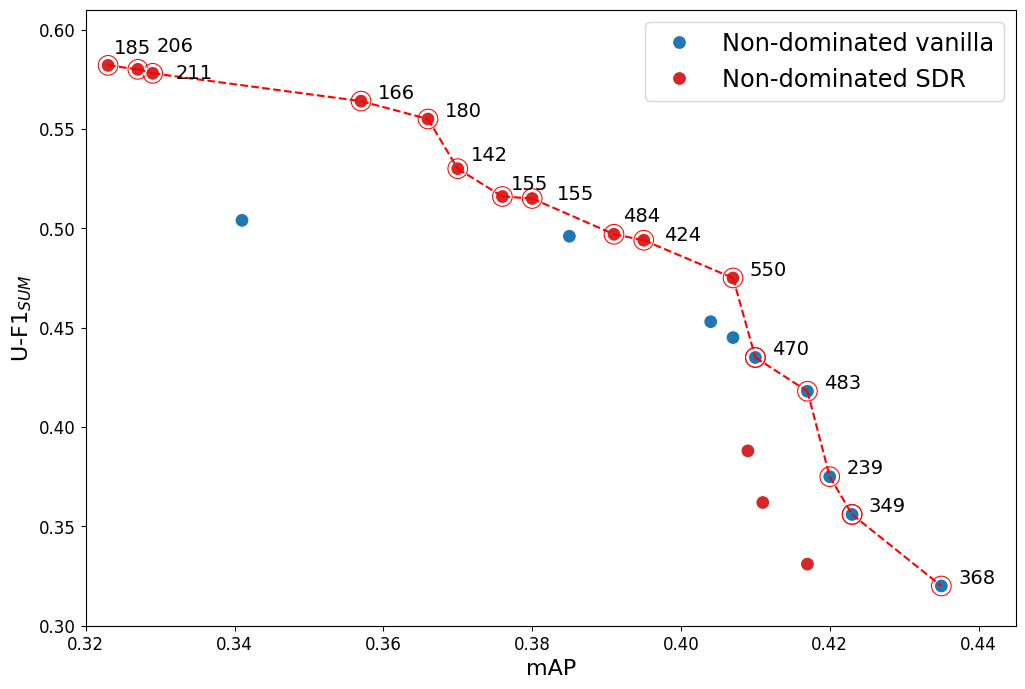

In [43]:
# Constants for the style of the plots
STYLE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR']
HUE_ORDER = ['Non-dominated vanilla', 'Non-dominated SDR']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated EUL': 'P',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True

# Constants
USE_LIMS = True
XLIM = (0.32, 0.445)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.096, 0.203)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.19, 0.405)
else:
    YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Cluster Method',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="best")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_SUBSET}_cluster_methods_non-dominated_comparison.pdf', bbox_inches='tight')
plt.show()

## RQ2. Post-hoc methods

### Option 1. Post-hoc methods one figure and then non-dominated of post-hoc against cluster methods non-dominated solutions

First the post-hoc methods non-dominated solutions

In [44]:
folders_to_consider = [
    Path("results/logits_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_logits = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_logits.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_logits = df_final.iloc[non_dominated_points]

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.head()

[PosixPath('results/logits_methods/20240713_151540_conf_thr_test_MSP.csv'), PosixPath('results/logits_methods/20240713_154800_conf_thr_test_Energy.csv'), PosixPath('results/logits_methods/20240713_154839_conf_thr_test_ODIN.csv')]
['MSP' 'Energy' 'ODIN']
['-']


,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM)
0,MSP,-,0.45,0.692,0.171,0.205,0.850,0.116,0.433,0.055,0.069,0.302,0.039,98,0.069,0.274
1,MSP,-,0.30,0.706,0.171,0.278,0.778,0.169,0.440,0.055,0.106,0.311,0.064,108,0.070,0.384
2,MSP,-,0.15,0.717,0.237,0.343,0.687,0.229,0.444,0.083,0.157,0.296,0.106,117,0.072,0.500
3,MSP,-,0.10,0.717,0.237,0.368,0.644,0.258,0.446,0.083,0.173,0.278,0.126,119,0.074,0.541
4,MSP,-,0.05,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576


/tmp/ipykernel_200460/1751653882.py:47: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


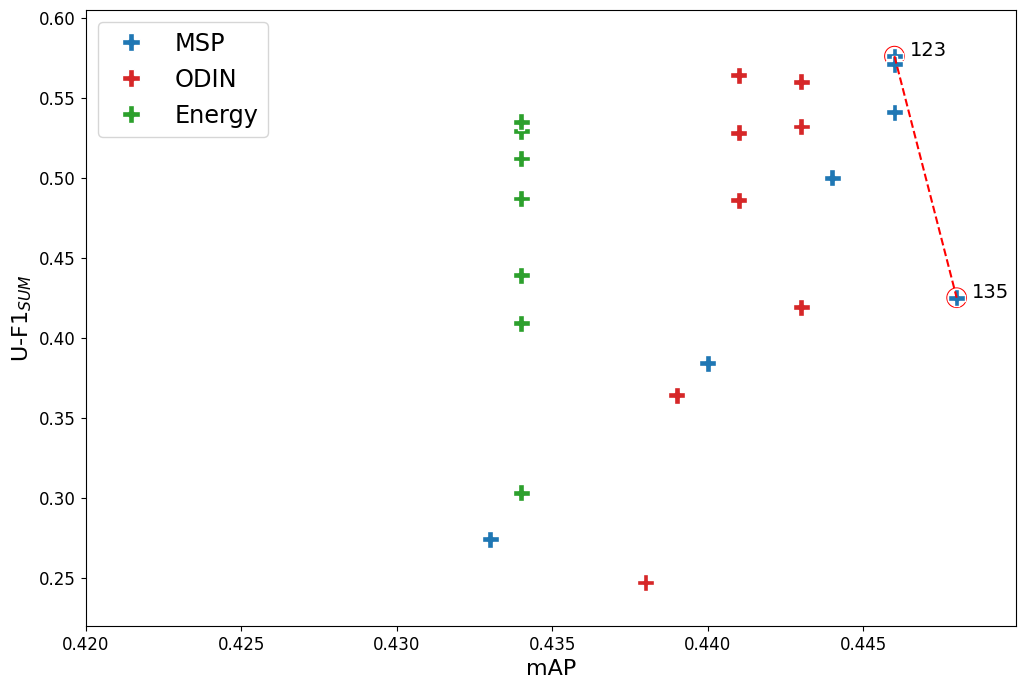

In [45]:
# Constants for the style of the plots
STYLE_ORDER = ['MSP', 'ODIN', 'Energy']
HUE_ORDER = ['MSP', 'ODIN', 'Energy']
#HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$', '$ND_{prev}$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True
AUTOMATIC_TEXT_ADJUSTMENT = False

# Constants
XLIM = (0.42, 0.4499)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.027, 0.195)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.22, 0.605)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'  # You can use 'small', 'medium', 'large', 'x-large', etc.
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_SDR_and_logits = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[4], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                hue='Method',  hue_order=HUE_ORDER, 
                style='Method', style_order=STYLE_ORDER,
                s=MARKER_SIZE, markers=MARKERS,
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE, AUTOMATIC_TEXT_ADJUSTMENT,
                                     offset_pos=0.0005, offset_neg=-0.007)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_SUBSET}_best_cluster_methods_against_logits.pdf', bbox_inches='tight')
plt.show()

Now the non-dominated solutions of post-hoc against non-dominated solutions from cluster methods

In [46]:
# Collect the non-dominated points of the cluster methods and post hoc
# Name cluster methods as them as f"Non-dominated distance"" and add them to the df
# Name the post hoc methods as Non-dominated post-hoc and add them to the df

# Cluster methods
# Vanilla
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_cluster_methods.copy()
df_non_dominated_cluster_methods_new_names['Distance'] = 'Non-dominated distance'
df_non_dominated_cluster_methods_new_names['Cluster Method'] = 'Non-dominated distance'
# SDR
df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
df_non_dominated_cluster_methods_SDR_new_names['Distance'] = 'Non-dominated distance'
df_non_dominated_cluster_methods_SDR_new_names['Cluster Method'] = 'Non-dominated distance'

# Post-hoc
df_non_dominated_logits_new_names = df_non_dominated_logits.copy()
df_non_dominated_logits_new_names['Distance'] = 'Non-dominated post-hoc'
df_non_dominated_logits_new_names['Cluster Method'] = 'Non-dominated post-hoc'

# Concatenate the dataframes
df_non_dominated_distance_vs_posthoc_methods = pd.concat([df_non_dominated_cluster_methods_new_names, df_non_dominated_cluster_methods_SDR_new_names, df_non_dominated_logits_new_names]).reset_index(drop=True)

# Rename the Distance to Method
df_non_dominated_distance_vs_posthoc_methods = df_non_dominated_distance_vs_posthoc_methods.rename(columns={'Distance': 'Method'})

df_final = df_non_dominated_distance_vs_posthoc_methods.copy()
df_final.head()

,Distance Metric,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Method,Method
0,Cosine,Non-dominated distance,0.050,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139,0.356,Non-dominated distance,NaN
1,Cosine,Non-dominated distance,0.010,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141,0.435,Non-dominated distance,NaN
2,Cosine,Non-dominated distance,0.005,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136,0.453,Non-dominated distance,NaN
3,$L_2$,Non-dominated distance,0.010,0.529,0.225,0.331,0.412,0.277,0.341,0.042,0.173,0.162,0.186,284,0.118,0.504,Non-dominated distance,NaN
4,$L_1$,Non-dominated distance,0.050,0.662,0.152,0.209,0.578,0.127,0.435,0.022,0.111,0.216,0.075,368,0.141,0.320,Non-dominated distance,NaN


/tmp/ipykernel_200460/1072446436.py:50: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


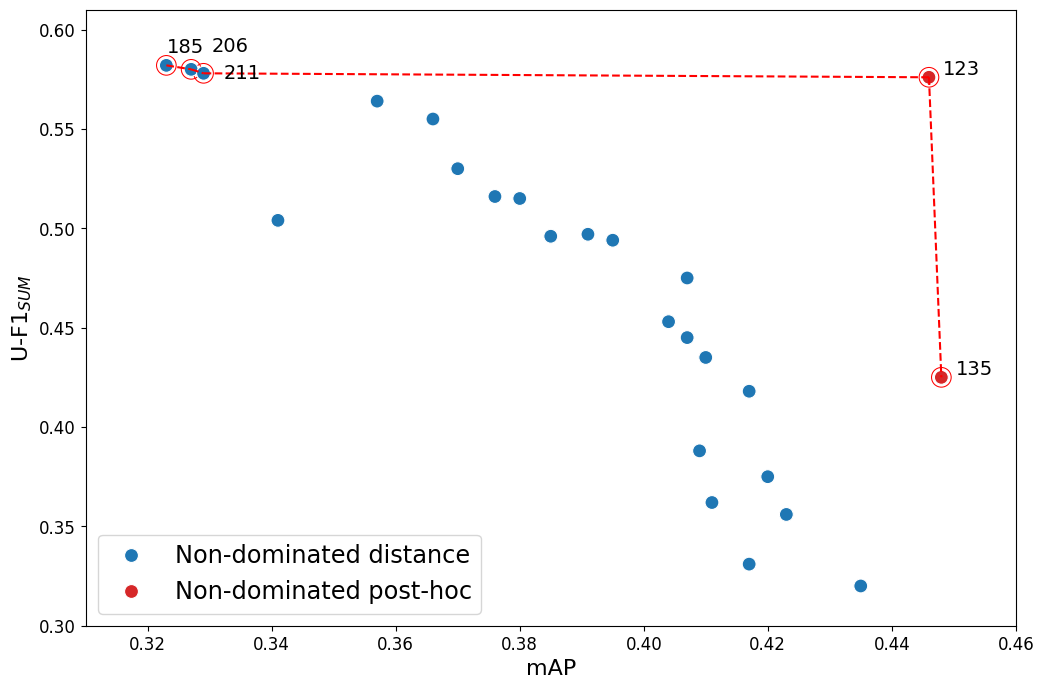

In [47]:
# Constants for the style of the plots
STYLE_ORDER = ['Non-dominated distance', 'Non-dominated post-hoc']
HUE_ORDER = ['Non-dominated distance', 'Non-dominated post-hoc']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated EUL': 'P',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True

# Constants
USE_LIMS = True
XLIM = (0.31, 0.46)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.098, 0.198)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Cluster Method',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND, loc="best")
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_SUBSET}_distance_vs_posthoc:methods_non-dominated_comparison.pdf', bbox_inches='tight')
plt.show()

### Option 2

In [48]:
# Obtain the best methods from clusters and SDR, with and without names
df_non_dominated_all_cluster_methods = df_final_cluster_methods_with_names.iloc[non_dominated_points]
df_non_dominated_all_cluster_methods_no_names = df_final_cluster_methods.iloc[non_dominated_points]
# Remove names of Distance and Cluster Method
df_non_dominated_all_cluster_methods_no_names['Distance'] = '$ND_{prev}$'
df_non_dominated_all_cluster_methods_no_names['Cluster Method'] = '$ND_{prev}$'
# Rename Distance as Method
df_non_dominated_all_cluster_methods_no_names = df_non_dominated_all_cluster_methods_no_names.rename(columns={'Distance': 'Method'})
# Assert same methods are selected
assert (df_non_dominated_all_cluster_methods_no_names['U-F1_(SUM)']).equals(df_non_dominated_all_cluster_methods['U-F1_(SUM)'])
df_non_dominated_all_cluster_methods_no_names.head()

/tmp/ipykernel_200460/1297017058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_dominated_all_cluster_methods_no_names['Distance'] = '$ND_{prev}$'
/tmp/ipykernel_200460/1297017058.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_dominated_all_cluster_methods_no_names['Cluster Method'] = '$ND_{prev}$'


,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Distance Metric
15,$ND_{prev}$,$ND_{prev}$,0.001,0.398,0.333,0.308,0.228,0.474,0.270,0.067,0.149,0.098,0.316,282,0.087,0.457,NaN
17,$ND_{prev}$,$ND_{prev}$,0.300,0.571,0.164,0.187,0.789,0.106,0.363,0.021,0.077,0.227,0.046,153,0.087,0.264,NaN
26,$ND_{prev}$,$ND_{prev}$,0.150,0.542,0.241,0.336,0.705,0.220,0.373,0.049,0.148,0.269,0.102,136,0.083,0.484,NaN
27,$ND_{prev}$,$ND_{prev}$,0.100,0.520,0.241,0.362,0.663,0.249,0.370,0.049,0.168,0.266,0.123,142,0.082,0.530,NaN
28,$ND_{prev}$,$ND_{prev}$,0.050,0.507,0.241,0.384,0.581,0.287,0.357,0.047,0.180,0.235,0.145,166,0.085,0.564,NaN


In [49]:
folders_to_consider = [
    Path("results/logits_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_logits = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final = df_logits.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_logits = df_final.iloc[non_dominated_points]

# Obtain the non-dominated points with info about the distance metric and cluster method
df_final = pd.concat([df_final, df_non_dominated_all_cluster_methods_no_names]).reset_index(drop=True)

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.head()

[PosixPath('results/logits_methods/20240713_151540_conf_thr_test_MSP.csv'), PosixPath('results/logits_methods/20240713_154800_conf_thr_test_Energy.csv'), PosixPath('results/logits_methods/20240713_154839_conf_thr_test_ODIN.csv')]
['MSP' 'Energy' 'ODIN' '$ND_{prev}$']
['-' '$ND_{prev}$']


,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Distance Metric
0,MSP,-,0.45,0.692,0.171,0.205,0.850,0.116,0.433,0.055,0.069,0.302,0.039,98,0.069,0.274,NaN
1,MSP,-,0.30,0.706,0.171,0.278,0.778,0.169,0.440,0.055,0.106,0.311,0.064,108,0.070,0.384,NaN
2,MSP,-,0.15,0.717,0.237,0.343,0.687,0.229,0.444,0.083,0.157,0.296,0.106,117,0.072,0.500,NaN
3,MSP,-,0.10,0.717,0.237,0.368,0.644,0.258,0.446,0.083,0.173,0.278,0.126,119,0.074,0.541,NaN
4,MSP,-,0.05,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,NaN


/tmp/ipykernel_200460/232884888.py:46: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


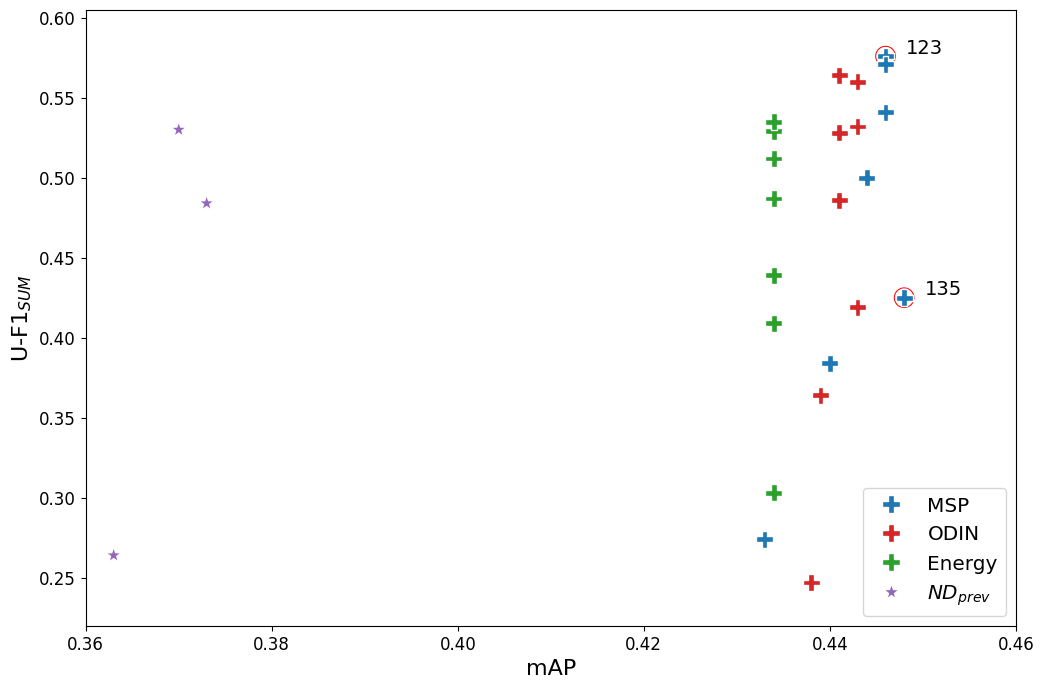

In [50]:
# Constants for the style of the plots
STYLE_ORDER = ['MSP', 'ODIN', 'Energy', '$ND_{prev}$']
HUE_ORDER = ['MSP', 'ODIN', 'Energy', '$ND_{prev}$']
#HUE_ORDER = ['$One$', '$KMeans$', '$KMeans^{10}$', '$HDBSCAN$', '$ND_{prev}$']

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = False
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True

# Constants
USE_LIMS = True
XLIM = (0.36, 0.46)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.198)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.22, 0.605)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'x-large'  # You can use 'small', 'medium', 'large', 'x-large', etc.
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_SDR_and_logits = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[4], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                hue='Method',  hue_order=HUE_ORDER, 
                style='Method', style_order=STYLE_ORDER,
                s=MARKER_SIZE, markers=MARKERS,
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ2_FIGURES_FOLDER / f'{WHICH_SUBSET}_best_cluster_methods_against_best_logits.pdf', bbox_inches='tight')
plt.show()

## RQ3. Fusion

AQUI ES IMPORTANTE TENER UNA FIGURA DONDE SE VEA QUE USAR MSP es casi lo mismo que MSP + post-hoc method

#### Option 1: Obtain first the non-dominated solutions of the fusion methods, then compare them

So first the non-dominated solutions of the fusion methods

In [51]:
folders_to_consider = [
    Path("results/fusion_methods")
]
df = convert_list_of_paths_into_df(folders_to_consider)
df.reset_index(drop=True, inplace=True)
df_fusion_methods = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_fusion_methods.reset_index(drop=True, inplace=True)
df_final = df_fusion_methods.copy()

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'fusion_strat': 'Fusion Strategy'})

# Obtain the logits non-dominated points
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_fusion_methods = df_final.iloc[non_dominated_points]

# Add MSP values to the df_final
df_msp = df_logits[df_logits['Method'] == 'MSP']
df_msp['fusion_strat'] = 'none'
df_msp = df_msp.rename(columns={'cluster_method': 'Cluster Method'})
df_msp = df_msp.rename(columns={'fusion_strat': 'Fusion Strategy'})
df_final = pd.concat([df_final, df_msp]).reset_index(drop=True)

print(df_final['Method'].unique())
print(df_final['Cluster Method'].unique())
df_final.tail()

[PosixPath('results/fusion_methods/and_20240718_143026_conf_thr_test_fusion-MSP-Cosine_cl_stride.csv'), PosixPath('results/fusion_methods/and_20240718_155057_conf_thr_test_fusion-Cosine_cl_stride-CosineIvis.csv'), PosixPath('results/fusion_methods/or_20240718_130429_conf_thr_test_fusion-Cosine_cl_stride-CosineIvis.csv'), PosixPath('results/fusion_methods/or_20240718_130301_conf_thr_test_fusion-MSP-Cosine_cl_stride.csv'), PosixPath('results/fusion_methods/score_20240718_195525_conf_thr_test_fusion-MSP-CosineIvis.csv'), PosixPath('results/fusion_methods/score_20240719_082249_conf_thr_test_fusion-MSP-Energy.csv'), PosixPath('results/fusion_methods/score_20240718_195459_conf_thr_test_fusion-MSP-Cosine_cl_stride.csv'), PosixPath('results/fusion_methods/and_20240719_082410_conf_thr_test_fusion-MSP-ODIN.csv'), PosixPath('results/fusion_methods/or_20240718_130236_conf_thr_test_fusion-MSP-Energy.csv'), PosixPath('results/fusion_methods/score_20240719_082220_conf_thr_test_fusion-MSP-ODIN.csv'), 

/tmp/ipykernel_200460/3508979459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp['fusion_strat'] = 'none'


,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Fusion Strategy
107,MSP,-,0.100,0.717,0.237,0.368,0.644,0.258,0.446,0.083,0.173,0.278,0.126,119,0.074,0.541,none
108,MSP,-,0.050,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,none
109,MSP,-,0.010,0.721,0.288,0.387,0.404,0.372,0.446,0.098,0.184,0.161,0.216,131,0.075,0.571,none
110,MSP,-,0.005,0.721,0.319,0.368,0.337,0.406,0.446,0.098,0.173,0.134,0.245,133,0.076,0.541,none
111,MSP,-,0.001,0.724,0.319,0.289,0.206,0.483,0.448,0.107,0.136,0.086,0.329,135,0.078,0.425,none


/tmp/ipykernel_200460/3663163987.py:52: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',  style='Method',


KeyError: 'fusion-MSP-ODIN'

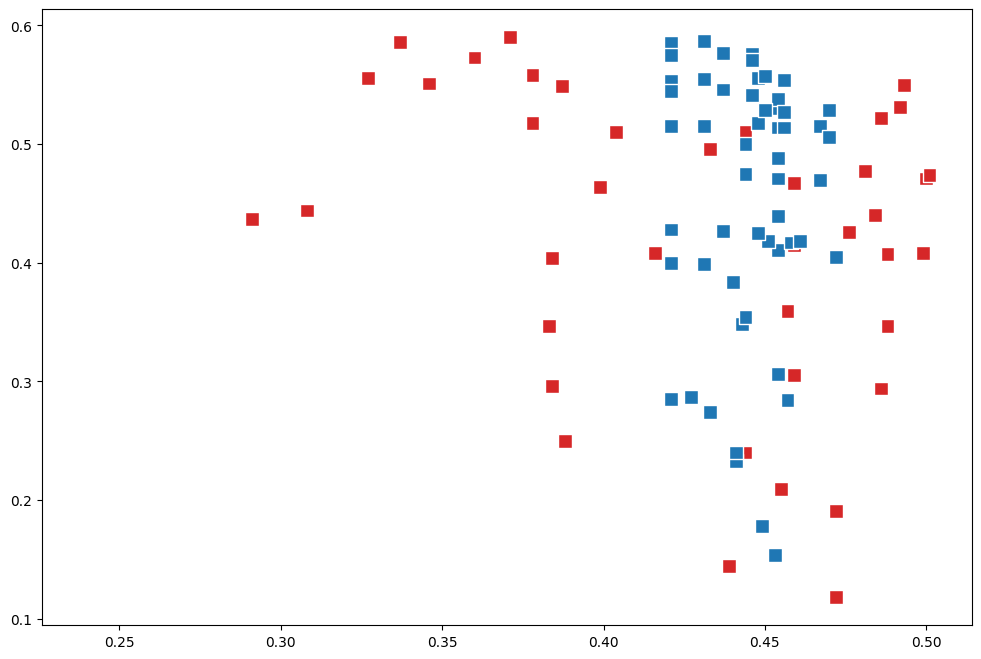

In [52]:
# Constants for the style of the plots
HUE_ORDER = ['-', '$HDBSCAN$', '$KMeans^{10}$-$HDBSCAN$']
STYLE_ORDER = ['MSP-Energy', 'MSP-Cosine', 'MSP-Cosine$^{SDR}$', 'Cosine-Cosine$^{SDR}$'] #, 'MSP']
OTHER_MARKERS = {
    'MSP-Energy': 's',
    'MSP-Cosine': 'D',
    'MSP-Cosine$^{SDR}$': 'o',
    'Cosine-Cosine$^{SDR}$': 'X',
    'MSP': '*',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True
USE_LIMS = True

# Constants
XLIM = (0.26, 0.515)
if WHICH_SUBSET == 'CMIX':
    YLIM = (0.025, 0.205)
elif WHICH_SUBSET == 'COOD':
    YLIM = (0.1, 0.415)
else:
    YLIM = (0.1, 0.7)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',  style='Method',
                hue='Cluster Method', 
                #hue='Fusion Strategy',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_SUBSET}_fusion_methods.pdf', bbox_inches='tight')
plt.show()

Then compare non-dominated solutions of fusion methods against non-dominated solutions of distance methods and post-hoc methods

In [ ]:
# Collect the non-dominated points of the cluster methods and post hoc
# Name cluster methods as them as f"Non-dominated distance"" and add them to the df
# Name the post hoc methods as Non-dominated post-hoc and add them to the df

# Cluster methods
# Vanilla
df_non_dominated_all_cluster_methods_new_names = df_non_dominated_cluster_methods.copy()
df_non_dominated_cluster_methods_new_names['Distance'] = 'Non-dominated distance'
df_non_dominated_cluster_methods_new_names['Cluster Method'] = 'Non-dominated distance'
# SDR
df_non_dominated_cluster_methods_SDR_new_names = df_non_dominated_cluster_methods_SDR.copy()
df_non_dominated_cluster_methods_SDR_new_names['Distance'] = 'Non-dominated distance'
df_non_dominated_cluster_methods_SDR_new_names['Cluster Method'] = 'Non-dominated distance'

# Post-hoc
df_non_dominated_logits_new_names = df_non_dominated_logits.copy()
df_non_dominated_logits_new_names['Distance'] = 'Non-dominated post-hoc'
df_non_dominated_logits_new_names['Cluster Method'] = 'Non-dominated post-hoc'

# Fusion
df_non_dominated_fusion_methods_new_names = df_non_dominated_fusion_methods.copy()
df_non_dominated_fusion_methods_new_names['Distance'] = 'Non-dominated fusion'
df_non_dominated_fusion_methods_new_names['Cluster Method'] = 'Non-dominated fusion'

# Concatenate the dataframes
df_non_dominated_distance_vs_posthoc_vs_fusion = pd.concat([
    df_non_dominated_cluster_methods_new_names,
    df_non_dominated_cluster_methods_SDR_new_names,
    df_non_dominated_logits_new_names,
    df_non_dominated_fusion_methods_new_names
]).reset_index(drop=True)

# Rename the Distance to Method
df_non_dominated_distance_vs_posthoc_vs_fusion = df_non_dominated_distance_vs_posthoc_vs_fusion.rename(columns={'Distance': 'Method'})

df_final = df_non_dominated_distance_vs_posthoc_vs_fusion.copy()
df_final.head()

,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Method
0,Non-dominated distance,Non-dominated distance,0.050,0.658,0.158,0.237,0.592,0.148,0.423,0.023,0.119,0.225,0.081,349,0.139,0.356,NaN
1,Non-dominated distance,Non-dominated distance,0.010,0.640,0.204,0.287,0.451,0.211,0.410,0.040,0.148,0.177,0.127,470,0.141,0.435,NaN
2,Non-dominated distance,Non-dominated distance,0.005,0.631,0.209,0.301,0.386,0.246,0.404,0.039,0.152,0.154,0.151,532,0.136,0.453,NaN
3,Non-dominated distance,Non-dominated distance,0.010,0.529,0.225,0.331,0.412,0.277,0.341,0.042,0.173,0.162,0.186,284,0.118,0.504,NaN
4,Non-dominated distance,Non-dominated distance,0.050,0.662,0.152,0.209,0.578,0.127,0.435,0.022,0.111,0.216,0.075,368,0.141,0.320,NaN


/tmp/ipykernel_166009/852556267.py:45: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})',


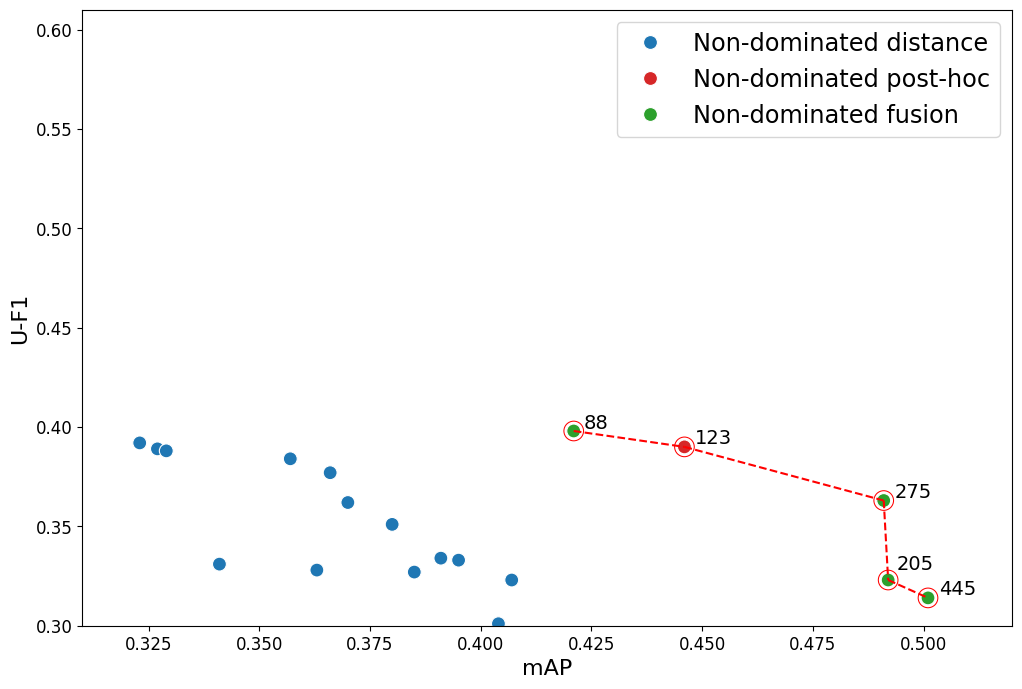

In [ ]:
# Constants for the style of the plots
STYLE_ORDER = ['Non-dominated distance', 'Non-dominated post-hoc', 'Non-dominated fusion']
HUE_ORDER = ['Non-dominated distance', 'Non-dominated post-hoc', 'Non-dominated fusion']
OTHER_MARKERS = {
    'Non-dominated vanilla': '*',
    'Non-dominated SDR': 'X',
    'Non-dominated fusion': 'P',
}

# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = True
USE_SHADED_AREAS = False
LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED = True

# Constants
USE_LIMS = True
XLIM = (0.31, 0.52)
YLIM = (0.3, 0.61)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'xx-large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 100
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods_and_SDR = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1], palette[4]]

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', 
                #style='Distance',
                hue='Cluster Method',
                s=MARKER_SIZE, hue_order=HUE_ORDER, 
                style_order=STYLE_ORDER,
                markers=OTHER_MARKERS,
                palette=colors_for_methods, ax=ax, legend='auto')

if USE_SHADED_AREAS:
    add_shaded_areas(df_final, ax, colors_for_methods, 'Cluster Method', 'mAP', f'U-F1_({WHICH_SUBSET})')

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    highlight_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', MARKER_SIZE_NON_DOMINATED, COLOR_NON_DOMINATED, LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    add_line_connecting_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', COLOR_NON_DOMINATED, '--', LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    add_text_to_non_dominated_points(ax, df_final, non_dominated_points, 'mAP', f'U-F1_({WHICH_SUBSET})', 'A-OSE', FONTSIZE_AOSE)

# Converts the legend to only show unique labels, basically is for removing the redundance of the Non-Dominated label
if LEGEND_WITH_ONLY_ONE_LABELS_FOR_NON_DOMINATED:
    unique_handles, unique_labels = unique_legend_handles_labels(ax)
    ax.legend(unique_handles, unique_labels, fontsize=FONTSIZE_LEGEND)
else:
    legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.

plt.savefig(RQ3_FIGURES_FOLDER / f'{WHICH_SUBSET}_distance_vs_posthoc_vs_fusion_non-dominated_comparison.pdf', bbox_inches='tight')
plt.show()

# OLD CODE

In [ ]:
raise Exception("Stop here")

Exception: Stop here

## 3D plot example

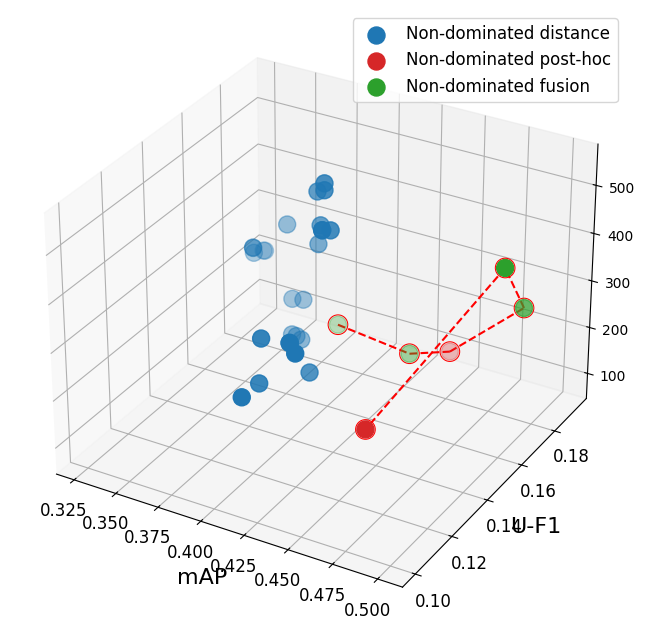

In [ ]:
# Configure plot
HIGHLIGHT_NON_DOMINATED_POINTS = True
CONNECT_NON_DOMINATED_POINTS = True
ADD_AOSE_VALUES = False
USE_SHADED_AREAS = False

# Constants
USE_LIMS = False
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1_aose(df_final, WHICH_SUBSET)
# Extract the non-dominated points into a df
df_non_dominated_cluster_methods = df_final.iloc[non_dominated_points]

# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Figure
# Figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    ax.scatter(subset['mAP'], subset[f'U-F1_({WHICH_SUBSET})'], subset['A-OSE'],
               s=MARKER_SIZE, label=method, color=color)

# sns.scatterplot(data=df_final, x='mAP', y=f'U-F1_({WHICH_SUBSET})', hue='Cluster Method', style='Distance',
#                 # Define sizes
#                 s=MARKER_SIZE, 
#                 #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
#                 palette=colors_for_methods, ax=ax, legend='brief')

if USE_SHADED_AREAS:
    # Adding shaded areas with adjustable amplitude (bandwidth)
    bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
    alpha_value = 0.2
    # Adding shaded areas
    for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
        subset = df_final[df_final['Cluster Method'] == method]
        sns.kdeplot(x=subset['mAP'], y=subset[f'U-F1_({WHICH_SUBSET})'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                    linewidth=0, levels=2)

if USE_LIMS:
    plt.xlim(XLIM)
    plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

if HIGHLIGHT_NON_DOMINATED_POINTS:
    # Highlight the non-dominated points
    for i in non_dominated_points:
        ax.scatter(df_final['mAP'][i], df_final[f'U-F1_({WHICH_SUBSET})'][i], df_final['A-OSE'][i], s=MARKER_SIZE_NON_DOMINATED, 
                #c='red',
                facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

if CONNECT_NON_DOMINATED_POINTS:
    # Add a line connecting the non-dominated points in descending order of U-F1
    non_dominated_points.sort(key=lambda x: df_final[f'U-F1_({WHICH_SUBSET})'][x], reverse=True)
    for i in range(len(non_dominated_points)-1):
        x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
        y = [df_final[f'U-F1_({WHICH_SUBSET})'][non_dominated_points[i]], df_final[f'U-F1_({WHICH_SUBSET})'][non_dominated_points[i+1]]]
        z = [df_final['A-OSE'][non_dominated_points[i]], df_final['A-OSE'][non_dominated_points[i+1]]]
        ax.plot(x, y, z, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

if ADD_AOSE_VALUES:
    # Add text to the non-dominated points with the value of A-OSE
    added_text_points = []
    for i in non_dominated_points:
        # Store the positions of the points
        x = df_final['mAP'][i]
        y = df_final[f'U-F1_({WHICH_SUBSET})'][i]
        z = df_final['A-OSE'][i]
        if (x, y) in added_text_points:
            continue
            ax.text(df_final['mAP'][i]-0.007, df_final[f'U-F1_({WHICH_SUBSET})'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
        else:
            ax.text(df_final['mAP'][i]+0.003, df_final[f'U-F1_({WHICH_SUBSET})'][i], df_final['A-OSE'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
        added_text_points.append((x, y, z))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(RQ1_FIGURES_FOLDER / f'{WHICH_SUBSET}_cluster_methods.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df_non_dominated_cluster_methods

,Method,Cluster Method,conf_thr_test,mAP_(VOC_test),U-AP_(COOD),U-F1_(COOD),U-PRE_(COOD),U-REC_(COOD),mAP,U-AP_(CMIX),U-F1_(CMIX),U-PRE_(CMIX),U-REC_(CMIX),A-OSE,WI-08,U-F1_(SUM),Method
26,Non-dominated post-hoc,Non-dominated post-hoc,0.050,0.719,0.237,0.390,0.565,0.298,0.446,0.083,0.186,0.237,0.153,123,0.073,0.576,MSP
27,Non-dominated post-hoc,Non-dominated post-hoc,0.001,0.724,0.319,0.289,0.206,0.483,0.448,0.107,0.136,0.086,0.329,135,0.078,0.425,MSP
28,Non-dominated fusion,Non-dominated fusion,0.050,0.668,0.286,0.398,0.559,0.310,0.421,0.078,0.187,0.214,0.167,88,0.066,0.585,MSP-Energy
29,Non-dominated fusion,Non-dominated fusion,0.050,0.567,0.289,0.397,0.563,0.307,0.371,0.048,0.193,0.222,0.171,79,0.057,0.590,MSP-Cosine
30,Non-dominated fusion,Non-dominated fusion,0.005,0.775,0.209,0.314,0.354,0.282,0.501,0.113,0.160,0.152,0.169,445,0.120,0.474,MSP-Cosine
31,Non-dominated fusion,Non-dominated fusion,0.010,0.763,0.275,0.363,0.415,0.322,0.491,0.106,0.183,0.194,0.174,275,0.094,0.546,MSP-Cosine$^{SDR}$


## Cluster methods

### Divide documents into normal and ivis

In [ ]:
documents_to_consider = Path("results/cluster_methods_results").rglob("*.csv")
documents_to_consider = list(documents_to_consider)
documents_to_consider

[PosixPath('results/cluster_methods_results/20240624_161311_cluster_methods_L1_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_234308_cluster_methods_L2Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240626_110430_cluster_methods_CosineIvis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_150107_cluster_methods_L1Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_105143_cluster_methods_Cosine_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_123436_cluster_methods_L2_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv')]

In [ ]:
normal_documents = [documents_to_consider[0], documents_to_consider[5], documents_to_consider[4]]
normal_documents

[PosixPath('results/cluster_methods_results/20240624_161311_cluster_methods_L1_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_123436_cluster_methods_L2_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240624_105143_cluster_methods_Cosine_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv')]

In [ ]:
ivis_documents = [documents_to_consider[3], documents_to_consider[1], documents_to_consider[2]]
ivis_documents

[PosixPath('results/cluster_methods_results/20240625_150107_cluster_methods_L1Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240625_234308_cluster_methods_L2Ivis_silhouette_conf_train0.15_conf_test0.15.csv'),
 PosixPath('results/cluster_methods_results/20240626_110430_cluster_methods_CosineIvis_silhouette_conf_train0.15_conf_test0.15.csv')]

### Normal

In [ ]:
normal_df = convert_list_of_paths_into_df(normal_documents)
normal_df.reset_index(drop=True, inplace=True)
normal_df_final = format_df(normal_df)
latex_str = normal_df_final.to_latex(**LATEX_PARAMS)
normal_df_final.to_latex(NORMAL_TEX_PATH, **LATEX_PARAMS)
normal_df_final.tail()

[PosixPath('results/cluster_methods_results/20240624_161311_cluster_methods_L1_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'), PosixPath('results/cluster_methods_results/20240624_123436_cluster_methods_L2_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv'), PosixPath('results/cluster_methods_results/20240624_105143_cluster_methods_Cosine_cl_stride_silhouette_conf_train0.15_conf_test0.15.csv')]


KeyError: "['U-F1_(SUM)'] not in index"

In [ ]:
# Convert the dataframe to a figure where the axes are the mAP and the U-F1
# Each method should be one type of point
# Each cluster method one color

# Create the figure

#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=normal_df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=200,
                #size='A-OSE', sizes=(100, 200), 
                ax=ax)
# Set the axis mAP=[0.35, 0.45] and U-F1=[0.7, 0.14]
ax.set_xlim(0.35, 0.45)
ax.set_ylim(0.07, 0.14)
# Instead of vertical and horizontal lines for the grid, use -45 degrees angled lines
# Define the limits of the plot
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

# Create angled grid lines
for x in np.arange(xlim[0], xlim[1], 5):
    plt.plot([xlim[0], xlim[1]], [ylim[0] + x, ylim[0] + x - (xlim[1] - xlim[0])], color='lightgrey', linestyle='--', linewidth=0.5)

for y in np.arange(ylim[0], ylim[1], 5):
    plt.plot([xlim[0] + y, xlim[0] + y - (ylim[1] - ylim[0])], [ylim[0], ylim[1]], color='lightgrey', linestyle='--', linewidth=0.5)
plt.title("Normal Methods")
plt.show()


In [ ]:
def format_latex_str(latex_str: str, mark_greater_values: Dict[str, float], mark_lower_values: Dict[str, float]) -> str:
    # Split the string into lines
    lines = latex_str.splitlines()
    # Add the midrules
    lines.insert(10, '\\midrule')
    lines.insert(17, '\\midrule')
    lines.insert(24, '\\midrule')
    # Join the lines back into a single string    
    final_latex_str = '\n'.join(lines)
    # Mark in bold and underline the greatest value of each column
    for col, value in mark_greater_values.items():
        # For each value, search for it in the string and change it to bold
        final_latex_str = final_latex_str.replace(str(value), '\\underline{\\textbf{' + str(value) + '}}')
    for col, value in mark_lower_values.items():
        # For each value, search for it in the string and change it to bold
        final_latex_str = final_latex_str.replace(str(value), '\\textbf{' + str(value) + '}')
    return final_latex_str

In [ ]:
max_values, min_values = obtain_best_values_of_columns(normal_df, columns_to_search_max=FINAL_COLUMNS[2:-2], columns_to_search_min=FINAL_COLUMNS[-2:])
final_latex_str = format_latex_str(latex_str, max_values, min_values)
# Save the final string to the file
with open(NORMAL_TEX_PATH, 'w') as f:
    f.write(final_latex_str)

### Ivis

In [ ]:
ivis_df = convert_list_of_paths_into_df(ivis_documents)
ivis_df.reset_index(drop=True, inplace=True)
ivis_df_final = format_df(ivis_df)
ivis_df_final.to_latex(IV_TEX_PATH, **LATEX_PARAMS)
ivis_df_final.tail()

## Pareto fronts

In [ ]:
folder_to_consider = Path("results/pareto_fronts")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

### Results without printing the pareto front

In [ ]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
plt.show()

In [ ]:
# Convert the dataframe to a figure where the axes are the mAP and the U-F1
# Each method should be one type of point
# Each cluster method one color

# Create the figure

#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
# Create a line between the points
sns.lineplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method', ax=ax, sort=False, legend=False)

In [ ]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method',
                # Define marker size
                s=100,
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                ax=ax,
                legend='brief')
# Create a line between the points
sns.lineplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='cluster_method', style='Method', ax=ax, sort=False, legend=False)

# Add a marker in each point with the value of A-OSE
for i in range(len(df_final)):
    #ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['conf_thr_test'][i], fontsize=12)
    # Put the value of A-OSE to the left of the point
    #ax.text(df_final['mAP'][i]-0.008, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=12)
    # Put the value of A-OSE to the right of the point
    ax.text(df_final['mAP'][i]+0.001, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=12)

### With Non-dominated solutions marked

In [ ]:
palette = sns.color_palette("tab10")
palette

In [ ]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.45)
YLIM = (0.025, 0.18)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)

# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.45)
YLIM = (0.025, 0.18)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

# RQ2. Resutls with logits

In [ ]:
folder_to_consider = Path("results/pareto_fronts_wtih_logits")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

In [ ]:
# Show method unique values
df_final['Method'].unique()

In [ ]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

### With CosineIvis and logits

In [ ]:
folder_to_consider = Path("results/pareto_fronts_with_ivis_and_logits")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

In [ ]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()

### Ivis with distance methods

In [ ]:
folder_to_consider = Path("results/pareto_fronts_with_ivis")
documents_to_consider = folder_to_consider.rglob("*.csv")
documents_to_consider = list(documents_to_consider)
df = convert_list_of_paths_into_df(documents_to_consider)
df.reset_index(drop=True, inplace=True)
df_final = format_df(df, columns_to_keep=FINAL_COLUMNS_WITH_CONF_THR)
df_final.tail()

In [ ]:
# Colors for the different cluster methods
palette = sns.color_palette("tab10")
colors_for_methods = [palette[0], palette[3], palette[2], palette[1]]

# Change the column name cluster_method to Cluster Method and Method to Distance
df_final = df_final.rename(columns={'cluster_method': 'Cluster Method'})
df_final = df_final.rename(columns={'Method': 'Distance'})

# Constants
XLIM = (0.26, 0.48)
YLIM = (0.025, 0.22)
FONTSIZE_XY_LABELS = 16
FONTSIZE_AOSE = 14
FONTSIZE_LEGEND = 'large'
FONTSIZE_TICKS = 12
MARKER_SIZE = 150
MARKER_SIZE_NON_DOMINATED = 200
LINEWIDTH_NON_DOMINATED_MARKER = 0.75
LINEWIDTH_NON_DOMINATED_LINE= 1.5
COLOR_NON_DOMINATED = 'red'

# Figure
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=df_final, x='mAP', y='U-F1_(CMIX)', hue='Cluster Method', style='Distance',
                # Define sizes
                s=MARKER_SIZE, 
                #size='A-OSE', sizes=(1, 200), size_norm=(0, 1000),
                palette=colors_for_methods, ax=ax, legend='brief')

# Adding shaded areas with adjustable amplitude (bandwidth)
bw_adjust_value = 0.3  # Adjust this value to modulate the amplitude
alpha_value = 0.2

# Adding shaded areas
for method, color in zip(df_final['Cluster Method'].unique(), colors_for_methods):
    subset = df_final[df_final['Cluster Method'] == method]
    sns.kdeplot(x=subset['mAP'], y=subset['U-F1_(CMIX)'], ax=ax, fill=True, color=color, alpha=alpha_value, legend=False, bw_adjust=bw_adjust_value,
                 linewidth=0, levels=2)

plt.xlim(XLIM)
plt.ylim(YLIM)
plt.xlabel('mAP', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.ylabel(f'U-F1$_{{{WHICH_SUBSET}}}$', fontdict={'fontsize': FONTSIZE_XY_LABELS})
plt.xticks(fontsize=FONTSIZE_TICKS)
plt.yticks(fontsize=FONTSIZE_TICKS)


# Search for the non dominated points
# These are any points that have no other point with a higher mAP and U-F1 at the same time
# For each point, check if there is any other point with a higher mAP and U-F1
# If there is not, then the point is non-dominated
non_dominated_points = obtain_non_dominated_points_positions_map_f1(df_final)

# Highlight the non-dominated points
for i in non_dominated_points:
    ax.scatter(df_final['mAP'][i], df_final['U-F1_(CMIX)'][i], s=MARKER_SIZE_NON_DOMINATED, 
               #c='red',
               facecolors='none', marker='o', zorder=0, edgecolors=COLOR_NON_DOMINATED, linewidths=LINEWIDTH_NON_DOMINATED_MARKER)

# Add a line connecting the non-dominated points in descending order of U-F1
non_dominated_points.sort(key=lambda x: df_final['U-F1_(CMIX)'][x], reverse=True)
for i in range(len(non_dominated_points)-1):
    x = [df_final['mAP'][non_dominated_points[i]], df_final['mAP'][non_dominated_points[i+1]]]
    y = [df_final['U-F1_(CMIX)'][non_dominated_points[i]], df_final['U-F1_(CMIX)'][non_dominated_points[i+1]]]
    ax.plot(x, y, c=COLOR_NON_DOMINATED, linestyle='--', linewidth=LINEWIDTH_NON_DOMINATED_LINE)

# Add text to the non-dominated points with the value of A-OSE
added_text_points = []
for i in non_dominated_points:
    # Store the positions of the points
    x = df_final['mAP'][i]
    y = df_final['U-F1_(CMIX)'][i]
    if (x, y) in added_text_points:
        continue
        ax.text(df_final['mAP'][i]-0.007, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    else:
        ax.text(df_final['mAP'][i]+0.003, df_final['U-F1_(CMIX)'][i], df_final['A-OSE'][i], fontsize=FONTSIZE_AOSE)
    added_text_points.append((x, y))

# Increase legend size
legend = ax.legend(fontsize=FONTSIZE_LEGEND)   # You can use 'small', 'medium', 'large', 'x-large', etc.
plt.savefig(folder_to_consider / 'pareto_fronts.pdf', bbox_inches='tight')
plt.show()